In [476]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\orlov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [477]:
def conf_matrix(val, pred):
    '''Визуализация матрицы ошибок'''
    cm = confusion_matrix(val, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [491]:
df = pd.read_csv('Disaster Tweets_Train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Посмотрим на распределения длин текстов в разных классах

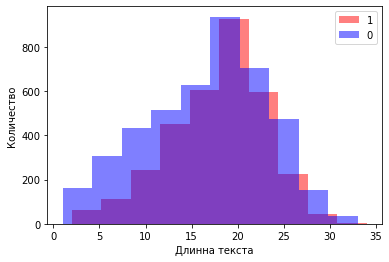

In [492]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df['tokens'] = df.text.apply(tokenizer.tokenize)
df['len_word'] = df.tokens.apply(lambda x: len(x))

plt.hist(df.len_word.loc[df.target == 1], bins=10, color='r', alpha = 0.5, label= 1)
plt.hist(df.len_word.loc[df.target == 0], bins=10, color='b', alpha = 0.5, label= 0)
plt.xlabel('Длинна текста')
plt.ylabel('Количество')

plt.legend()
plt.show()

Среди коротких постов(менее 15 слов) перевес в сторону нулевого класса

# Посмотрим на баланс классов

In [493]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

В качестве метрики будем ориентироваться на Accuracy т.к. дисбаланса классов не наблюдается

# Немного обработаем данные. Приведем все к нижнему регистру,оставим только английские слова и цифры,и удалим лишние пробелы

In [494]:
df.text = df.text.apply(lambda x: x.lower())
df.text = df.text.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
df.text = df.text.apply(lambda x: re.sub(r'\s+', ' ', x))
df.text.head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13 000 people receive wildfires evacuation ord...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Начнем с логистической регресии, и попробуем её в комбинации с CountVectorizer и TfidfVectorizer

Accuracy: 0.814


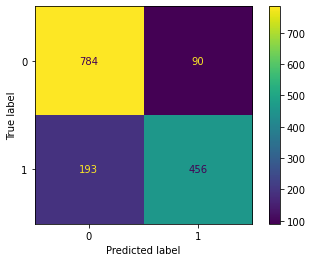

In [496]:
vec = CountVectorizer(ngram_range=(1, 2))
bow = vec.fit_transform(df.text)
X_train, X_test, y_train, y_test = train_test_split(bow, df.target, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, predicted),3)}')
conf_matrix(y_test, predicted)

Лучший вариант получается учитывая униграммы и биграммы

Accuracy: 0.802


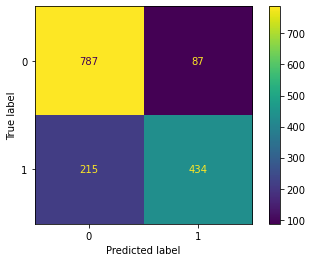

In [497]:
#Пробуем векторизацию на основе tf idf
vec = TfidfVectorizer()
bow = vec.fit_transform(df.text)
X_train, X_test, y_train, y_test = train_test_split(bow, df.target, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, predicted),3)}')
conf_matrix(y_test, predicted)

Попробуем классификатор на основе решающих деревьев, в комбинации с CountVectorizer и TfidfVectorizer

Accuracy: 0.78


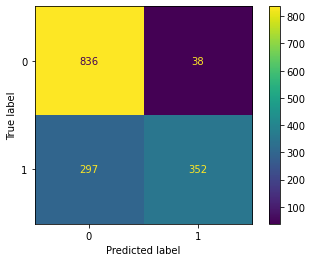

In [465]:
vec = CountVectorizer(ngram_range=(1, 2))
bow = vec.fit_transform(df.text)
X_train, X_test, y_train, y_test = train_test_split(bow, df.target, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, predicted),3)}')
conf_matrix(y_test, predicted)

Accuracy: 0.772


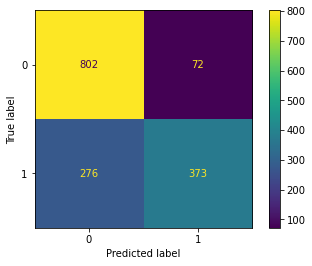

In [474]:
vec = TfidfVectorizer()
bow = vec.fit_transform(df.text)
X_train, X_test, y_train, y_test = train_test_split(bow, df.target, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, predicted),3)}')
conf_matrix(y_test, predicted)

Обучим Word2Vec

In [537]:
from gensim.models.word2vec import Word2Vec
%time model_tweets = Word2Vec(df.tokens, workers=4, vector_size=300, min_count=2, window=5, epochs=45)

Wall time: 10.9 s


Посмотрим на симантически близкие слова к слову "Катастрофа"

In [538]:
model_tweets.wv.most_similar('disaster')

[('natural', 0.8474053740501404),
 ('calamity', 0.7646089792251587),
 ('Chernobyl', 0.719546914100647),
 ('nuclear', 0.708290696144104),
 ('Fukushima', 0.695774257183075),
 ('declares', 0.6769752502441406),
 ('Obama', 0.6538925766944885),
 ('ticket', 0.650634765625),
 ('drill', 0.6490073800086975),
 ('Typhoon', 0.6416929960250854)]

Получилось неплохо

In [557]:
model_tweets.wv.most_similar('sea')

[('black', 0.6922954320907593),
 ('ocean', 0.6811925172805786),
 ('bottom', 0.6739025115966797),
 ('riot', 0.6646307706832886),
 ('valley', 0.6629976630210876),
 ('ground', 0.65892094373703),
 ('tent', 0.636087954044342),
 ('many', 0.632262647151947),
 ('work', 0.6288415789604187),
 ('crack', 0.6221959590911865)]

Для слова "Sea" получилось хуже

In [563]:
def get_text_embedding(text):
    """Функция получает эмбедденги из текстов.
    находит слова в словаре искладывает их.
    Если в тексте не нашлось слов, которые в нашем словаре Word2Vec,
    Вектор заполняется нулями"""
    result = []
    for words in text:
        for word in words:
            if word in model_tweets.wv:
                result.append(model_tweets.wv[word])

        if len(result):
            result = np.sum(result, axis=0)
        else:
            result = np.zeros(300)
        return result

In [564]:
features = [get_text_embedding(text) for text in tqdm(df.tokens)]


100%|███████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 19721.93it/s]


In [566]:
X_train, X_test, y_train, y_test = train_test_split(features, df.target, test_size=0.2)
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))


              precision    recall  f1-score   support

           0       0.63      0.58      0.60       881
           1       0.48      0.52      0.50       642

    accuracy                           0.56      1523
   macro avg       0.55      0.55      0.55      1523
weighted avg       0.56      0.56      0.56      1523



Результат не очень

# Попробуем скачать предобученную модель Word2Vec обученную на большом корпусе слов

In [272]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [435]:
glove_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [568]:
glove_vectors.most_similar('disaster')

[('catastrophe', 0.8395509719848633),
 ('disasters', 0.8315500617027283),
 ('calamity', 0.7899965643882751),
 ('disaster-', 0.7756001949310303),
 ('pre-disaster', 0.7697495818138123),
 ('post-disaster', 0.7656727433204651),
 ('non-disaster', 0.7601431012153625),
 ('near-disaster', 0.7580682635307312),
 ('predisaster', 0.7567157745361328),
 ('postdisaster', 0.7375972270965576)]

In [572]:
def get_text_embedding1(text):
    result = []
    for word in word_tokenize(text.lower()):
        if word in glove_vectors:
            result.append(glove_vectors[word])

    if len(result):
        result = np.mean(result, axis=0)
    else:
        result = np.zeros(300)
    return result

In [573]:
features = [get_text_embedding1(text) for text in tqdm(df.text)]



100%|████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:03<00:00, 2193.27it/s]


# Результат заметно лучше.

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       874
           1       0.80      0.68      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



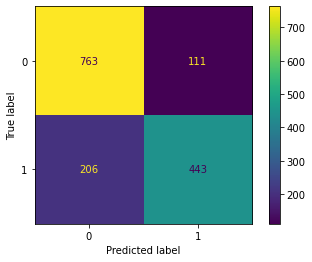

In [574]:
X_train, X_test, y_train, y_test = train_test_split(features, df.target, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))
conf_matrix(y_test, predicted)

# Итог:
    Лучше всего себя показал самый простой способ векторизации текста(CountVectorizer) и логистическая регрессия.
    Далее можно попробовать оптимизировать гиперпараметры с помощью Greadsearch